In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
#dataroot - the path to the root of the dataset folder. We will talk more about the dataset in the next section
#workers - the number of worker threads for loading the data with the DataLoader
#batch_size - the batch size used in training. The DCGAN paper uses a batch size of 128
#image_size - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details
#nc - number of color channels in the input images. For color images this is 3
#nz - length of latent vector
#ngf - relates to the depth of feature maps carried through the generator
#ndf - sets the depth of feature maps propagated through the discriminator
#num_epochs - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer
#lr - learning rate for training. As described in the DCGAN paper, this number should be 0.0002
#beta1 - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
#ngpu - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs

In [55]:
# Root directory for dataset
dataroot = "data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

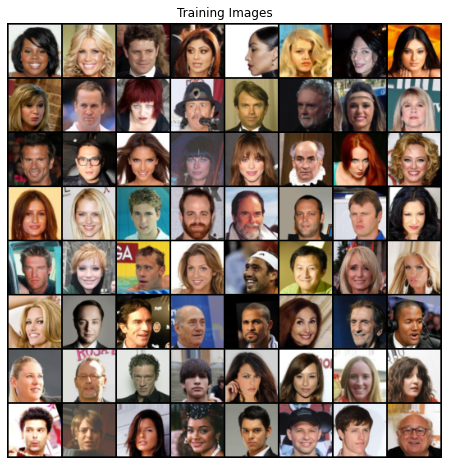

In [56]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [57]:
#Implementation
#With our input parameters set and the dataset prepared, 
#we can now get into the implementation. 
#We will start with the weight initialization strategy, 
#then talk about the generator, discriminator, loss functions, and training loop in detail.



In [58]:
#Weight Initialization

In [59]:
#From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from 
#a Normal distribution with mean=0,
#stdev=0.02.

In [60]:
#The weights_init function takes an initialized model as input and reinitializes all convolutional, 
#convolutional-transpose, and batch normalization layers to meet this criteria.
#This function is applied to the models immediately after initialization.

In [61]:

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    

In [62]:
#design Generator

#The generator, G, is designed to map the latent space vector (zz) to data-space
#Since our data are images,
#converting zz to data-space means ultimately creating a RGB image with the same size as the training images
#shape --> (i.e. 3x64x64)
#In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers,
#each paired with a 2d batch norm layer and a relu activation. 


In [63]:
# The output of the generator is fed through a tanh function
#to return it to the input data range of [-1,1][−1,1]

In [64]:
#It is worth noting the existence of the batch norm functions after the conv-transpose layers,
#as this is a critical contribution of the DCGAN paper.

In [65]:
#These layers help with the flow of gradients during training. 
#An image of the generator from the DCGAN paper is shown below.



In [66]:
#how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code

In [67]:
#nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator,
#and nc is the number of channels in the output image (set to 3 for RGB images)

In [68]:
# Generator Code

In [69]:
class generator(nn.Module):
    def __init__(self,ngpu):
        super(generator,self).__init__()
        self.ngpu=ngpu
        self.main=nn.Sequential(
        ## input is Z, going into a convolution
            nn.ConvTranspose2d(nz,ngf*8, 4, 1, 0,bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
             # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
            nn.Tanh()
        
        

        )
    
    
    def forward(self,input):
        return self.main(input)
        
        

In [70]:
#Now, we can instantiate the generator and apply the weights_init function.
#Check out the printed model to see how the generator object is structured.

In [71]:
#create the generator 
netG=generator(ngpu).to(device)

In [72]:
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

In [73]:
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [74]:
#Discriminator

In [75]:
#As mentioned, the discriminator, D, 
#is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake)

In [76]:
#Here, D takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, 
#and outputs the final probability through a Sigmoid activation function. 

In [77]:
#This architecture can be extended with more layers if necessary for the problem, 
#but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs.

In [78]:
#The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample 
#because it lets the network learn its own pooling function. 

In [79]:
 #Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process
    #of both GG and DD.

In [80]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [81]:
#Now, as with the generator, we can create the discriminator,
#apply the weights_init function, and print the model’s structure.

In [82]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [83]:
#Loss Functions and Optimizers
#With DD and GG setup, we can specify how they learn through the loss functions and optimizers.
#We will use the Binary Cross Entropy loss (BCELoss) 
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [84]:
# now that we have all of the parts of the GAN framework defined, 
#we can train it. Be mindful that training GANs is somewhat of an art form,
#as incorrect hyperparameter settings lead to mode collapse with little explanation of what went wrong

In [85]:
#Part 1 - Train the Discriminator

#Recall, the goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake. 
#In terms of Goodfellow, we wish to “update the discriminator by ascending its stochastic gradient”.

In [86]:
#Practically, we want to maximize log(D(x)) + log(1-D(G(z)))log
# Due to the separate mini-batch suggestion from ganhacks, we will calculate this in two steps.
#we will construct a batch of real samples from the training set, forward pass through DD
#then calculate the gradients in a backward pass.
#Secondly, we will construct a batch of fake samples with the current generator
#forward pass this batch through DD, calculate the loss
#and accumulate the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, 
#we call a step of the Discriminator’s optimizer.

In [87]:
#Part 2 - Train the Generator
#As stated in the original paper, we want to train the Generator by minimizing log(1-D(G(z)))log
#) in an effort to generate better fakes. As mentioned, this was shown by Goodfellow to not provide sufficient gradients, 
#especially early in the learning process
#As a fix, we instead wish to maximize log(D(G(z)))log(D(G(z)))
# In the code we accomplish this by: classifying the Generator output from Part 1 with the Discriminator,
# computing G’s loss using real labels as GT, computing G’s gradients in a backward pass, 
#and finally updating G’s parameters with an optimizer step.
# It may seem counter-intuitive to use the real labels as GT labels for the loss function,
#but this allows us to use the log(x) part of the BCELoss (rather than the log(1-x) part) 
#which is exactly what we want.


In [48]:
#we will do some statistic reporting and at the end of each epoch we will push our fixed_noise batch through the generator to visually track the progress of G’s training.
#The training statistics reported are:

In [49]:
#Loss_D - discriminator loss calculated as the sum of losses for the all real and all fake batches (log(D(x)) + log(1 - D(G(z)))).

In [50]:
#Loss_G - generator loss calculated as log(D(G(z)))

In [51]:
#D(x) - the average output (across the batch) of the discriminator for the all real batch. 
#This should start close to 1 then theoretically converge to 0.5 when G gets better. Think about why this is.
#because as the generator enhances , the probablility of fooling the discriminator becomes higher

In [52]:
#D(G(z)) - average discriminator outputs for the all fake batch.
#The first number is before D is updated and the second number is after D is updated. 
#These numbers should start near 0 and converge to 0.5 as G gets better.
#Think about why this is.


In [88]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/706]	Loss_D: 1.8361	Loss_G: 5.7784	D(x): 0.5675	D(G(z)): 0.6328 / 0.0048
[0/5][50/706]	Loss_D: 0.0934	Loss_G: 30.3210	D(x): 0.9677	D(G(z)): 0.0000 / 0.0000
[0/5][100/706]	Loss_D: 0.0289	Loss_G: 14.6288	D(x): 0.9784	D(G(z)): 0.0008 / 0.0000
[0/5][150/706]	Loss_D: 0.0003	Loss_G: 42.6703	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/5][200/706]	Loss_D: 0.0000	Loss_G: 42.4881	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][250/706]	Loss_D: 0.0056	Loss_G: 42.3289	D(x): 0.9959	D(G(z)): 0.0000 / 0.0000
[0/5][300/706]	Loss_D: 0.0005	Loss_G: 40.5875	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[0/5][350/706]	Loss_D: 0.9183	Loss_G: 6.4141	D(x): 0.9693	D(G(z)): 0.5277 / 0.0084
[0/5][400/706]	Loss_D: 0.6642	Loss_G: 6.0877	D(x): 0.9224	D(G(z)): 0.3513 / 0.0036
[0/5][450/706]	Loss_D: 0.8840	Loss_G: 3.1632	D(x): 0.5186	D(G(z)): 0.0573 / 0.0586
[0/5][500/706]	Loss_D: 0.9024	Loss_G: 2.3510	D(x): 0.5274	D(G(z)): 0.0703 / 0.1170
[0/5][550/706]	Loss_D: 1.0156	Loss_G: 4.1640	D(x): 0.4806	

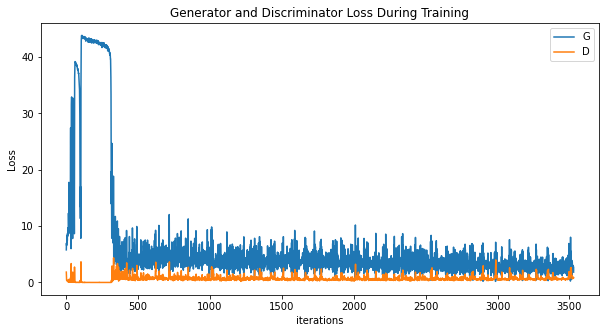

In [89]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

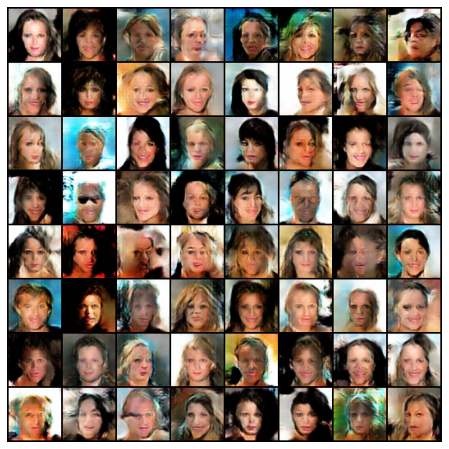

In [90]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

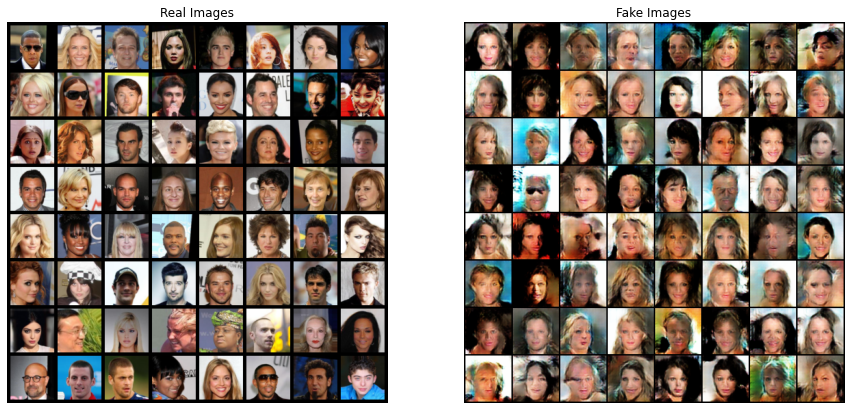

In [91]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()